In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import random
from hmmlearn import hmm
from tensorflow.keras import models, Model
from tensorflow.keras.layers import LSTM, Input, GRU, SimpleRNN, Bidirectional, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

In [3]:
df = pd.read_csv('data-kiem-tra-2.csv', encoding='latin-1', sep=',')
df2 = np.loadtxt("data-kiem-tra-2.csv",encoding='latin-1', delimiter=',',skiprows=1, usecols=(2), dtype=float)

In [4]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

In [5]:
df = df.drop_duplicates(subset=['date'])

In [6]:
df.head()

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,2013-05-10,4,58,3773,299.0,1
1,2013-05-26,4,58,3768,249.0,1
2,2013-05-19,4,58,4036,419.0,1
3,2013-05-25,4,58,12878,149.0,1
4,2013-05-15,4,58,12885,148.0,1


In [7]:
df = df.sort_values(by='date')
df.index = np.arange(1, len(df)+1)

In [45]:
df

,date,truong_1,truong_2,truong_3,truong_4,truong_5
1,2013-05-01,4,59,2436,799.0,1
2,2013-05-02,4,59,2739,2299.0,2
3,2013-05-03,4,59,2730,499.0,1
4,2013-05-04,4,59,2738,1839.0,1
5,2013-05-05,4,59,2257,299.0,1
...,...,...,...,...,...,...
210,2013-11-26,10,28,9324,589.0,1
211,2013-11-27,10,28,11030,149.0,1
212,2013-11-28,10,28,10298,399.0,1
213,2013-11-29,10,28,10292,99.0,1


In [8]:
columns = ['truong_1', 'truong_2', 'truong_3', 'truong_4', 'truong_5']

In [9]:
data = df[columns]

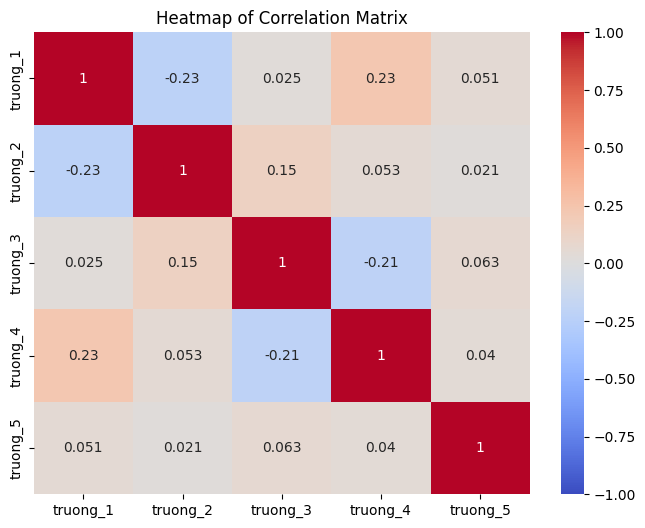

In [10]:
correlation_matrix = data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Heatmap of Correlation Matrix')
plt.show()


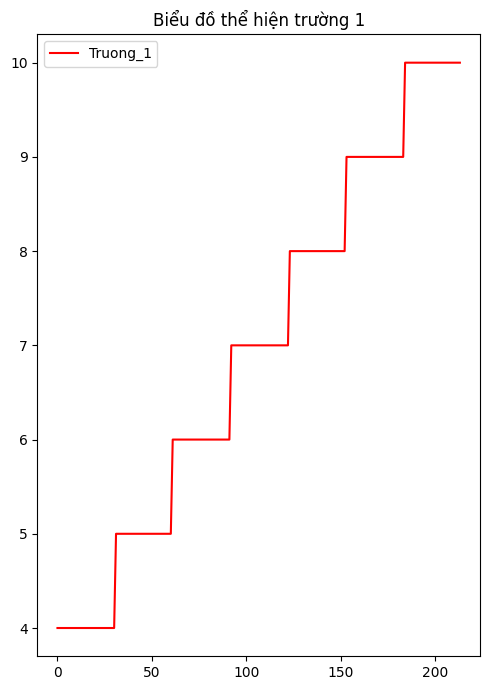

In [11]:
plt.figure(figsize=(5, 7))

plt.plot(range(data['truong_1'].shape[0]), data['truong_1'], 'red', label='Truong_1')
plt.title(f'Biểu đồ thể hiện trường 1')
plt.legend()

plt.tight_layout()
plt.show()

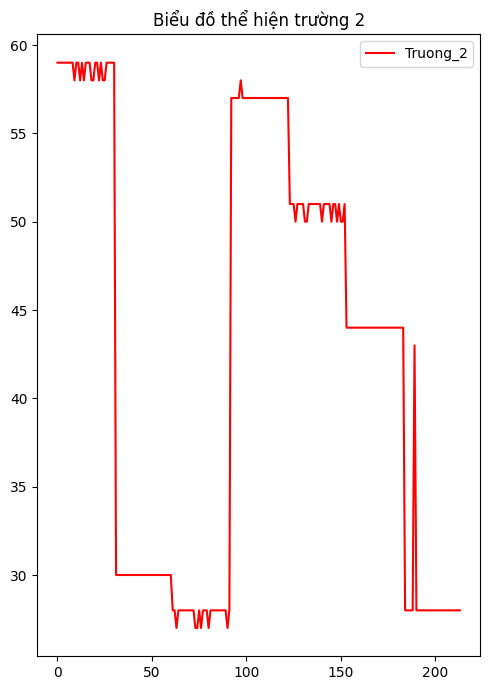

In [12]:
plt.figure(figsize=(5, 7))

plt.plot(range(data['truong_2'].shape[0]), data['truong_2'], 'red', label='Truong_2')
plt.title(f'Biểu đồ thể hiện trường 2')
plt.legend()

plt.tight_layout()
plt.show()

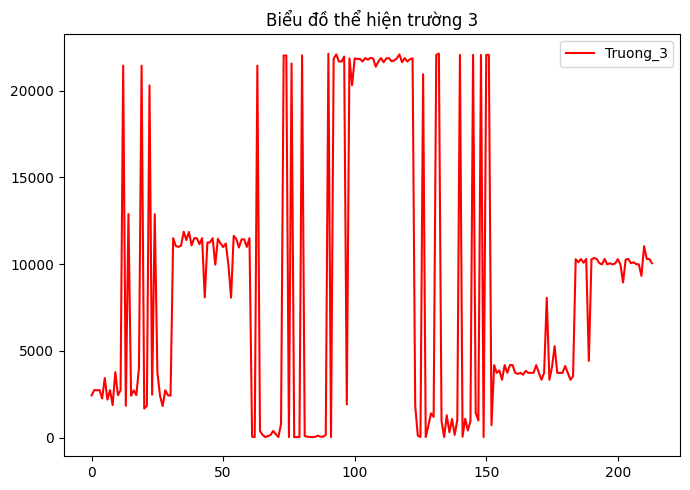

In [13]:
plt.figure(figsize=(7, 5))

plt.plot(range(data['truong_3'].shape[0]), data['truong_3'], 'red', label='Truong_3')
plt.title(f'Biểu đồ thể hiện trường 3')
plt.legend()

plt.tight_layout()
plt.show()

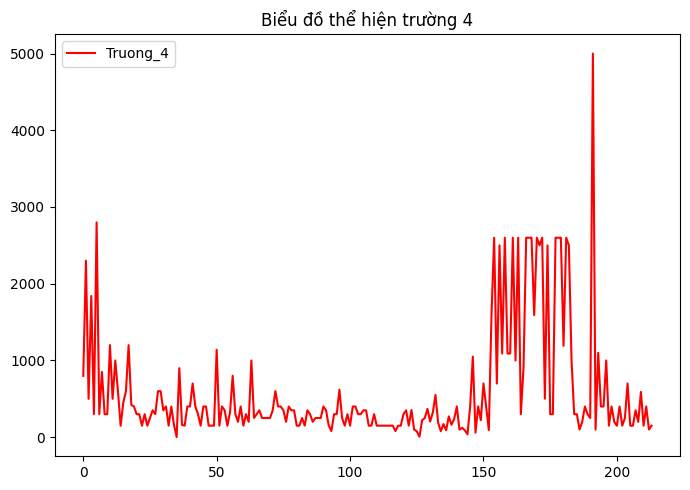

In [14]:
plt.figure(figsize=(7, 5))

plt.plot(range(data['truong_4'].shape[0]), data['truong_4'], 'red', label='Truong_4')
plt.title(f'Biểu đồ thể hiện trường 4')
plt.legend()

plt.tight_layout()
plt.show()

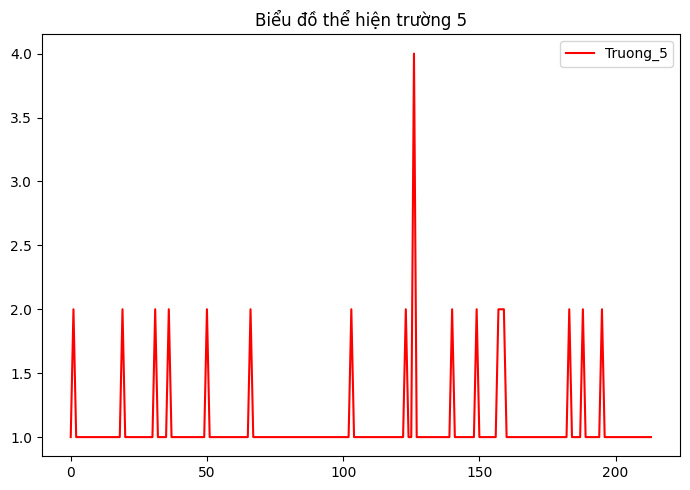

In [15]:
plt.figure(figsize=(7, 5))

plt.plot(range(data['truong_5'].shape[0]), data['truong_5'], 'red', label='Truong_5')
plt.title(f'Biểu đồ thể hiện trường 5')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
TEST_SIZE = 50

In [17]:
def measure_metric(y_true, y_pred):
    e = y_true - y_pred
    r2=r2_score(y_true, y_pred)
    mse=np.mean(e**2)
    rmse=np.sqrt(mse)
    mae=np.mean(np.abs(e))
    mape = mean_absolute_percentage_error(y_true, y_pred)

    print('R2: {}'.format(r2))
    print('MSE: {}'.format(mse))
    print('RMSE: {}'.format(rmse))
    print('MAE: {}'.format(mae))
    print('MAPE: {}'.format(mape))
    return [r2, mse, rmse, mae, mape]

In [18]:
dict_single_step = {
    'R2': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'MAPE': []
}

In [19]:
metric_df_single_step = pd.DataFrame(dict_single_step)

In [20]:
class SingleStep:
    
    def __init__(self, data: pd.DataFrame, look_back=10):
        
        # Lưu dữ liệu thành array thay vì DataFrame
        self.df = data.copy()
        self.data = self.df.values

        # Scaler dữ liệu
        self.scaler = StandardScaler()
        self.normalized_data = self.scaler.fit_transform(self.data)
        
        # Số lượng mẫu trong tập dữ liệu
        self.time_steps = data.shape[0] 
        
        # Số lượng đặc trưng
        self.n_columns = data.shape[1]

        # Số lượng ngày để dự đoán look_back -> output 
        self.look_back = look_back

    def data_mapping(self):
        
        mapping_steps = self.look_back + 1
        
        iterations = self.time_steps - mapping_steps + 1
        self.normalized_data_mapped = np.empty((iterations, mapping_steps, self.n_columns))
        
        for i in range(iterations):
            self.normalized_data_mapped[i, :, :] = self.normalized_data[i:i + mapping_steps, :]
        
        return self.normalized_data_mapped
    
    def train_test_split(self, test_size):
        
        self.test_size = test_size
        self.train_size = self.normalized_data_mapped.shape[0] - self.test_size
        
        # normalized_data_mapped đã chứa số look_back+1 nên chỉ việc lấy look_back ở phần trước cho tập train và để lại giá trị cuối cùng là của tập test
        X_train = self.normalized_data_mapped[:self.train_size, :-1, :]
        y_train = self.normalized_data_mapped[:self.train_size, -1, :]
        
        X_test = self.normalized_data_mapped[self.train_size:, :-1, :]
        y_test = self.normalized_data_mapped[self.train_size:, -1, :]
        
        return X_train, X_test, y_train, y_test  

    def forecast_n_steps(self, model, data: pd.DataFrame, n_forecast_steps=15):
        
        # Scaling dữ liệu của chuỗi look back. last_steps shape = (self.look_back, self.n_columns)
        last_steps = self.scaler.transform(data.values)[-self.look_back:]
    
        # Định nghĩa 1 mẫu dữ liệu để dữ đoán output với shape = (n_forecast_steps, self.look_back, self.n_columns) để có thể fit từng mẫu vào mô hình dự đoán ra output
        normalized_data_mapped = np.empty((n_forecast_steps, self.look_back, self.n_columns))
    
        # Khởi tạo tập dự đoán chứa n_forecast_steps dự đoán từ mô hình
        predictions = np.empty((n_forecast_steps, self.n_columns))
    
        # Dự đoán trước 1 step
        normalized_data_mapped[0, :, :] = last_steps
        predictions[0, :] = model.predict(
            normalized_data_mapped[0, :, :].reshape(1, self.look_back, self.n_columns),
            verbose=False
        )
        # Tạo ra n_forecast_steps dự đoán mới từ look back và 1 step đã dự đoán
        for i in range(1, n_forecast_steps):
            # Loại bỏ quan sát ở đầu ra và thêm phán đoán mới vào chuỗi
            normalized_data_mapped[i, :-1, :] = normalized_data_mapped[i - 1, 1:, :]
            normalized_data_mapped[i, -1, :] = predictions[i - 1, :]
    
            # Dự đoán quan sát tiếp theo
            norm_data = normalized_data_mapped[i, :, :].reshape(1, self.look_back, self.n_columns)
            predictions[i, :] = model.predict(norm_data, verbose=False)
    
        # Inverse dữ liệu 
        predictions = self.scaler.inverse_transform(predictions)
        return predictions

In [21]:
columns = ['truong_1']

In [22]:
look_back = 5
# Fit dữ liệu để setup dữ liệu cho mô hình
data_model = SingleStep(data[columns], look_back)

# Scaled dữ liệu
scaled_data_mapped = data_model.data_mapping()

In [23]:
X_train, X_test, y_train, y_test = data_model.train_test_split(test_size=TEST_SIZE)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((159, 5, 1), (50, 5, 1), (159, 1), (50, 1))

In [25]:
def lstm_single_step_model():
    input = Input(shape=X_train[0].shape)
    x = LSTM(units=64, return_sequences=True)(input)
    x = LSTM(units=32, return_sequences=False)(x)
    x = Dense(units=16, activation='relu')(x)
    output = Dense(units=len(columns))(x)
    
    model = Model(inputs=input, outputs=[output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [26]:
model = lstm_single_step_model()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_loss', save_best_only=True)

In [28]:
history = model.fit(X_train, 
                        y_train, 
                        epochs=50, 
                        batch_size=16, 
                        validation_data=(X_test, y_test), 
                        verbose=False,
                        callbacks=[model_checkpoint])

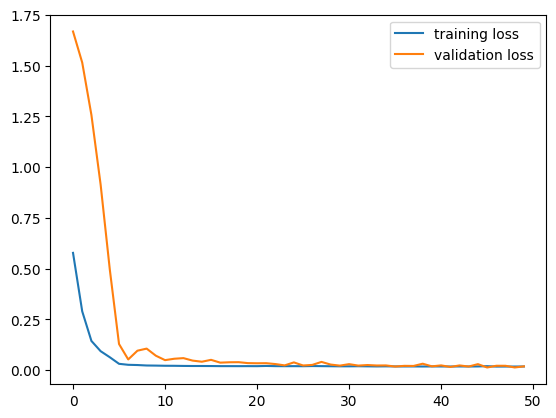

In [29]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label ='validation loss')
plt.legend()
plt.show()

In [30]:
model = models.load_model('model.keras')

In [31]:
result = model.evaluate(X_test, y_test)
y_pred_model = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148  
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step


In [32]:
y_test_actual = data_model.scaler.inverse_transform(y_test)
y_test_pred = data_model.scaler.inverse_transform(y_pred_model)

In [33]:
MAPE = mean_absolute_percentage_error(y_test_pred, y_test_actual)
Accuracy = 1 - MAPE
print(f" % sai số dự báo và thực tế {MAPE * 100}")
print(f"Độ chính xác của mô hình: {Accuracy * 100}")

 % sai số dự báo và thực tế 1.687027013044238
Độ chính xác của mô hình: 98.31297298695576


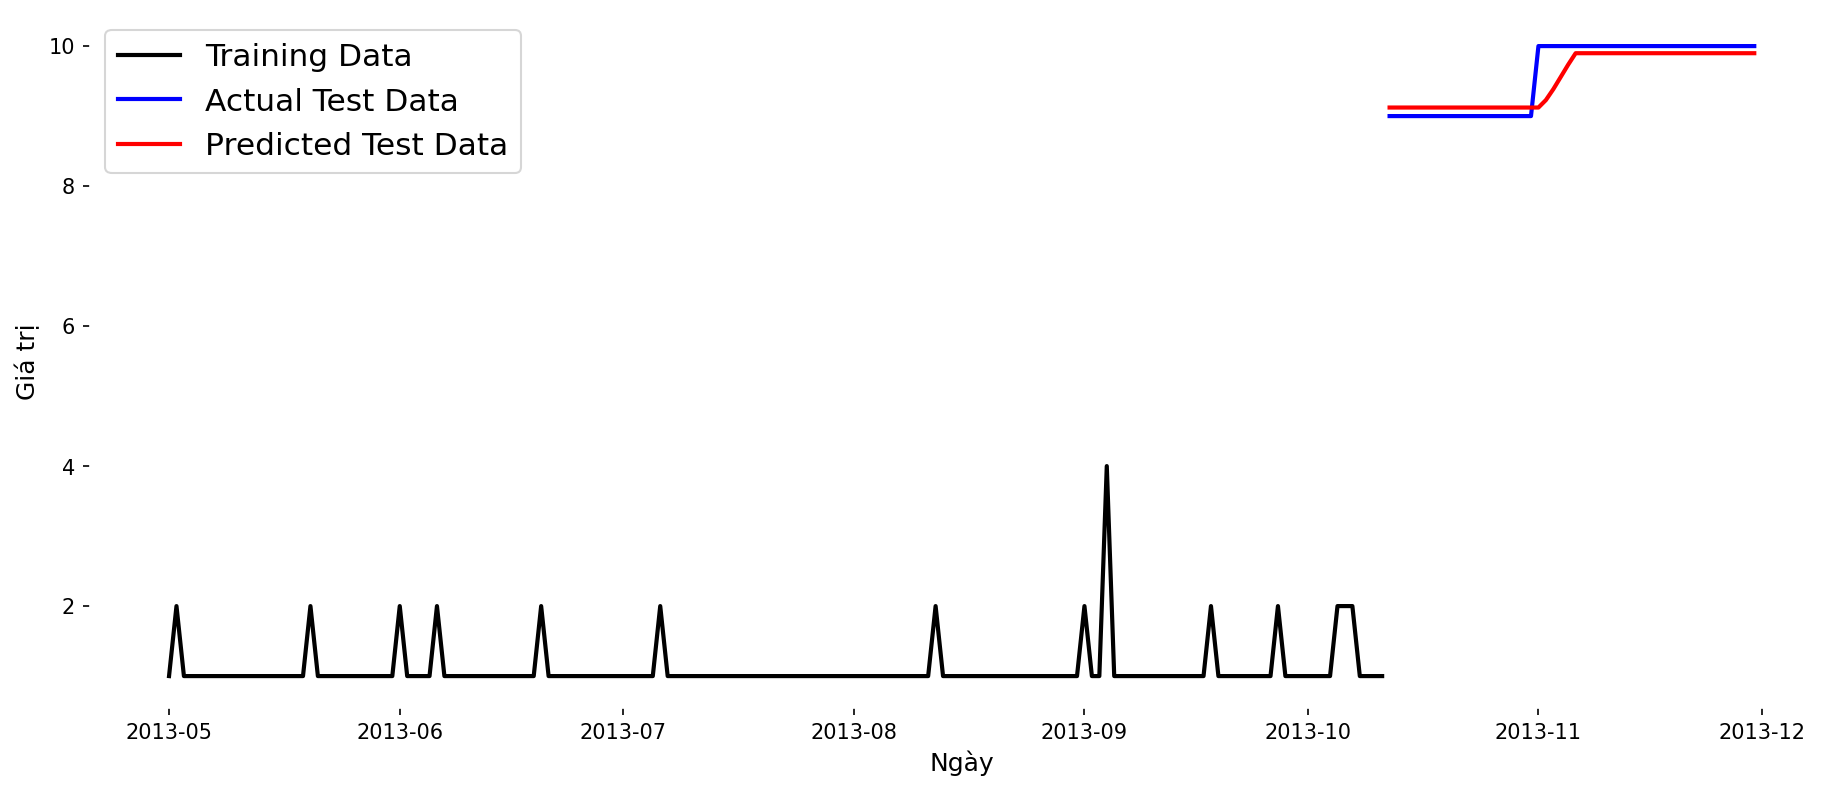

In [34]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='white')
plt.plot(df['date'].iloc[:-TEST_SIZE], df['truong_5'].iloc[:-TEST_SIZE], color='black', lw=2)
plt.plot(df['date'].iloc[-TEST_SIZE:], y_test_actual, color='blue', lw=2)
plt.plot(df['date'].iloc[-TEST_SIZE:], y_test_pred, color='red', lw=2)
plt.xlabel('Ngày', fontsize=12)
plt.ylabel('Giá trị', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [36]:
print(df2)

[58. 58. 58. ... 37. 37. 37.]


In [37]:
df2=df2.reshape(-1,1)

In [38]:
# Khởi tạo HMM
model = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=1000)

# Huấn luyện HMM với dữ liệu quan sát
model.fit(df2)

# In ra các tham số của mô hình sau khi huấn luyện
print("Start probabilities: ", model.startprob_)
print("Transition matrix: ", model.transmat_)
print("Means: ", model.means_)
print("Covariances: ", model.covars_)

Start probabilities:  [0.9091939 0.0908061]
Transition matrix:  [[0.38071893 0.61928107]
 [0.91013162 0.08986838]]
Means:  [[33.00719539]
 [33.00656348]]
Covariances:  [[[271.30853353]]

 [[271.30821614]]]


In [41]:
# Dự đoán trạng thái ẩn cho các quan sát hiện có
hidden_states = model.predict(df2)
print("Hidden states: ", hidden_states)

# Lấy mẫu mới từ mô hình đã huấn luyện
X, Z = model.sample(5)  # Lấy mẫu 5 quan sát mới
print("Sampled observations: ", X)
print("Sampled hidden states: ", Z)

Hidden states:  [0 1 0 ... 1 0 1]
Sampled observations:  [[62.04672523]
 [27.34100345]
 [39.39527808]
 [48.91391514]
 [25.07969079]]
Sampled hidden states:  [0 0 1 0 0]


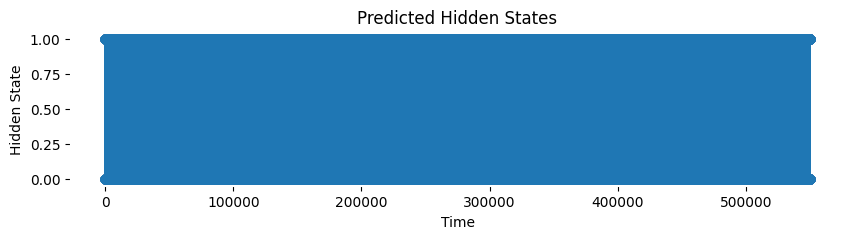

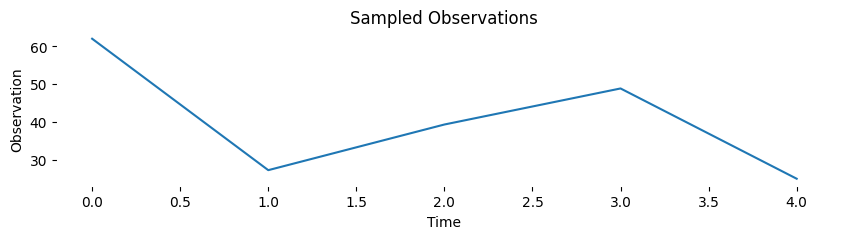

In [42]:
# Vẽ các trạng thái ẩn dự đoán
def plot_hidden_states(hidden_states, title):
    plt.figure(figsize=(10, 2))
    plt.plot(hidden_states, marker='o')
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Hidden State")
    plt.show()

plot_hidden_states(hidden_states, "Predicted Hidden States")

# Vẽ các quan sát mẫu
def plot_observations(observations, title):
    plt.figure(figsize=(10, 2)) 
    plt.plot(observations)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Observation")
    plt.show()

plot_observations(X, "Sampled Observations")